У цьому ДЗ ми потренуємось розв'язувати задачу багатокласової класифікації за допомогою логістичної регресії з використанням стратегій One-vs-Rest та One-vs-One, оцінити якість моделей та порівняти стратегії.

#Imports


In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier


from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer



from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTETomek

from google.colab import drive

pd.set_option('display.max.rows',130)
pd.set_option('display.max.columns',130)
pd.set_option('float_format', '{:.2f}'.format)

#Functions

In [132]:
def info_df_null_n(df):
    df_null = ['Work_Experience', 'Family_Size']


    for col_r in df_null:
        mean = round(df[col_r].mean(), 2)
        mode = df[col_r].mode()[0]
        median = df[col_r].median()
        print(f'Назва колонки: {col_r}')
        qua = df[col_r].quantile(q = [0.25,0.5,0.75, 0.99, 1])
        null_percentage_1 = round((df[col_r].isnull().sum()/df.shape[0])*100, 2)

        print(f'Середнє значення: {mean}')
        print(f'Мода: {mode}')
        print(f'Медіана: {median}')
        print(f'Персентилі: {qua}')
        print(f'Відсоток пропущених значень: {null_percentage_1}')
        print("\n")
        sns.boxplot(df[col_r])
        plt.show()

def info_df_null_c(df):
    df_null = ['Ever_Married', 'Graduated', 'Profession', 'Var_1']


    for col_r in df_null:
        print(f'Назва колонки: {col_r}')
        per_n = df[col_r].value_counts(normalize = True)
        null_percentage_1 = round((df[col_r].isnull().sum()/df.shape[0])*100, 2)
        print (f'Значення у відсотках:{per_n}')
        print(f'Відсоток пропущених значень: {null_percentage_1}')
        print("\n")
        plt.figure(figsize = (10,5))
        sns.countplot(data = df, x = col_r)
        plt.xticks(rotation = 90)
        plt.show()

def hip_2(df):
    mean_experience = df['Work_Experience'].mean()
    df['Work_Experience'].fillna(value=round((mean_experience),0), inplace = True)
    median_exp = df['Family_Size'].median()
    df['Family_Size'].fillna(value = (median_exp), inplace = True)

    df['Ever_Married'].fillna(value = 'Unknown', inplace = True)

    df['Graduated'].fillna(value = 'Unknown', inplace = True)

    df['Profession'].fillna(value = 'Unknown', inplace = True)

    df['Var_1'].fillna(value = 'Unknown', inplace = True)

    return df

def encod(df, categorical_cols):
    enc = preprocessing.OneHotEncoder()
    enc_mapping = enc
    enc.fit(df[categorical_cols])
    one_hot = enc.transform(df[categorical_cols])

    #Обєднання колонок після енкодера
    encoded_df = pd.DataFrame(one_hot.toarray(), columns=enc.get_feature_names_out(categorical_cols))
    #однакові індекси
    encoded_df.index = df.index
    encoded_categories = enc.get_feature_names_out(categorical_cols)
    # Додаємо закодовані дані до train_inputs
    inputs_enc = pd.concat([df, encoded_df], axis=1)
    # Видаляємо початкові категоріальні стовпці, якщо потрібно
    inputs_enc.drop(categorical_cols, axis=1, inplace=True)

    return inputs_enc, encoded_categories, enc_mapping

def minmax_df_train(inputs_enc, numeric_cols):
    scaler = MinMaxScaler()
    df_numeric_scaled = scaler.fit_transform(inputs_enc[numeric_cols])
    numeric_df = pd.DataFrame(df_numeric_scaled, columns=numeric_cols)
    numeric_df.index = inputs_enc.index

    for col in numeric_cols:
         inputs_enc[col] = inputs_enc.index.map(numeric_df.set_index(numeric_df.index)[col])
         encoded_numeric_df = inputs_enc

    return encoded_numeric_df, scaler

def stomenc_df_train(encoded_numeric_df, encoded_categories, targets):
    categorical_indices = [encoded_numeric_df.columns.get_loc(col) for col in encoded_categories]
    smotenc = SMOTENC(categorical_features = categorical_indices)
    X_smotenc, y_smotenc = smotenc.fit_resample(encoded_numeric_df, targets)

    return X_smotenc, y_smotenc

### Опис задачі і даних

**Контекст**

В цьому ДЗ ми працюємо з даними про сегментацію клієнтів.

Сегментація клієнтів – це практика поділу бази клієнтів на групи індивідів, які схожі між собою за певними критеріями, що мають значення для маркетингу, такими як вік, стать, інтереси та звички у витратах.

Компанії, які використовують сегментацію клієнтів, виходять з того, що кожен клієнт є унікальним і що їхні маркетингові зусилля будуть більш ефективними, якщо вони орієнтуватимуться на конкретні, менші групи зі зверненнями, які ці споживачі вважатимуть доречними та які спонукатимуть їх до купівлі. Компанії також сподіваються отримати глибше розуміння уподобань та потреб своїх клієнтів з метою виявлення того, що кожен сегмент цінує найбільше, щоб точніше адаптувати маркетингові матеріали до цього сегменту.

**Зміст**.

Автомобільна компанія планує вийти на нові ринки зі своїми існуючими продуктами (P1, P2, P3, P4 і P5). Після інтенсивного маркетингового дослідження вони дійшли висновку, що поведінка нового ринку схожа на їхній існуючий ринок.

На своєму існуючому ринку команда з продажу класифікувала всіх клієнтів на 4 сегменти (A, B, C, D). Потім вони здійснювали сегментовані звернення та комунікацію з різними сегментами клієнтів. Ця стратегія працювала для них надзвичайно добре. Вони планують використати ту саму стратегію на нових ринках і визначили 2627 нових потенційних клієнтів.

Ви маєте допомогти менеджеру передбачити правильну групу для нових клієнтів.

В цьому ДЗ використовуємо дані `customer_segmentation_train.csv`[скачати дані](https://drive.google.com/file/d/1VU1y2EwaHkVfr5RZ1U4MPWjeflAusK3w/view?usp=sharing). Це `train.csv`з цього [змагання](https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation/data?select=train.csv)

#Завдання 1

**Завдання 1.** Завантажте та підготуйте датасет до аналізу. Виконайте обробку пропущених значень та необхідне кодування категоріальних ознак. Розбийте на тренувальну і тестувальну вибірку, де в тесті 20%. Памʼятаємо, що весь препроцесинг ліпше все ж тренувати на тренувальній вибірці і на тестувальній лише використовувати вже натреновані трансформери.
Але в даному випадку оскільки значень в категоріях небагато, можна зробити обробку і на оригінальних даних, а потім розбити - це простіше. Можна також реалізувати процесинг і тренування моделі з пайплайнами. Обирайте як вам зручніше.

In [ ]:
path_to_data = '/content/drive/MyDrive/Python/ML/DATA/customer_segmentation_train.csv'

In [ ]:
#Read data
drive.mount('/content/drive')

Mounted at /content/drive


In [133]:
df = pd.read_csv(path_to_data)

###Аналіз даних

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [93]:
null_count = df.isnull().sum()
null_percentage = round((df.isnull().sum()/df.shape[0])*100, 2)
null_df = pd.DataFrame({'column_name' : df.columns,'null_count' : null_count,'null_percentage': null_percentage})
null_df.reset_index(drop = True, inplace = True)
null_df.sort_values(by = 'null_percentage', ascending = False)

,column_name,null_count,null_percentage
6,Work_Experience,829,10.28
8,Family_Size,335,4.15
2,Ever_Married,140,1.74
5,Profession,124,1.54
4,Graduated,78,0.97
9,Var_1,76,0.94
0,ID,0,0.00
1,Gender,0,0.00
3,Age,0,0.00
7,Spending_Score,0,0.00


Назва колонки: Work_Experience
Середнє значення: 2.64
Мода: 1.0
Медіана: 1.0
Персентилі: 0.25    0.00
0.50    1.00
0.75    4.00
0.99   13.00
1.00   14.00
Name: Work_Experience, dtype: float64
Відсоток пропущених значень: 10.28




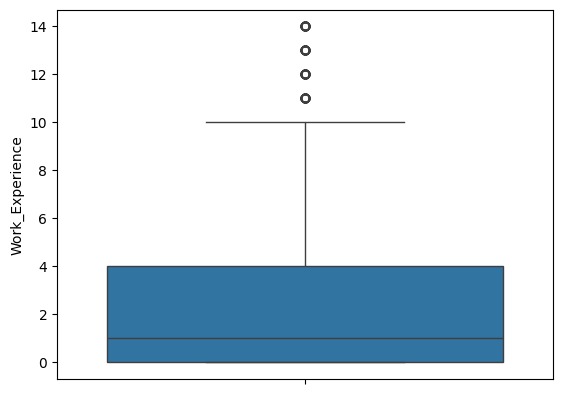

Назва колонки: Family_Size
Середнє значення: 2.85
Мода: 2.0
Медіана: 3.0
Персентилі: 0.25   2.00
0.50   3.00
0.75   4.00
0.99   8.00
1.00   9.00
Name: Family_Size, dtype: float64
Відсоток пропущених значень: 4.15




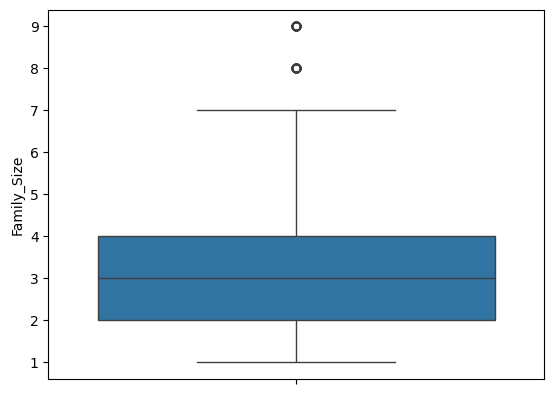

In [95]:
info_df_null_n(df)

Назва колонки: Ever_Married
Значення у відсотках:Ever_Married
Yes   0.59
No    0.41
Name: proportion, dtype: float64
Відсоток пропущених значень: 1.74




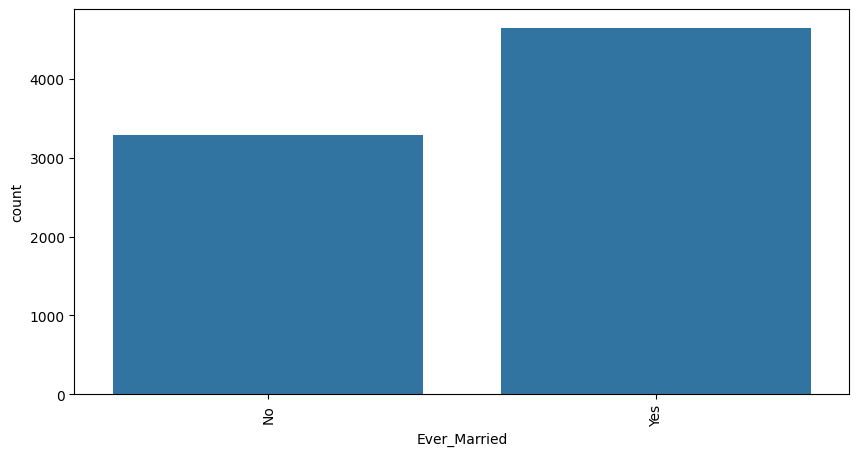

Назва колонки: Graduated
Значення у відсотках:Graduated
Yes   0.62
No    0.38
Name: proportion, dtype: float64
Відсоток пропущених значень: 0.97




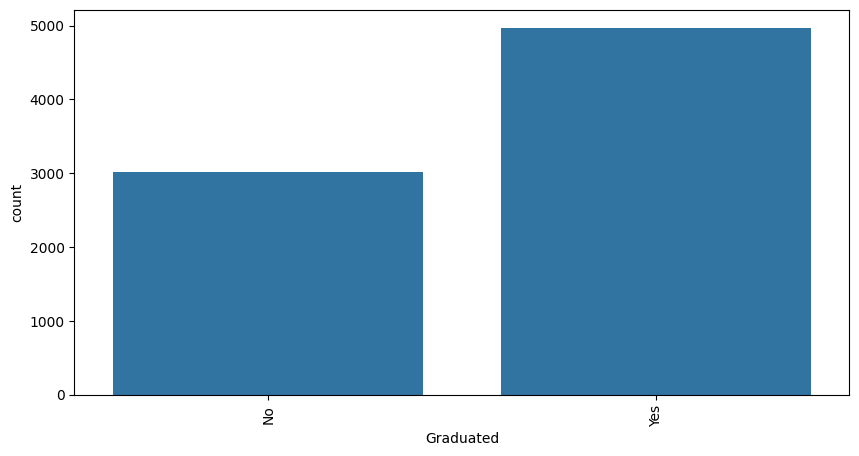

Назва колонки: Profession
Значення у відсотках:Profession
Artist          0.32
Healthcare      0.17
Entertainment   0.12
Engineer        0.09
Doctor          0.09
Lawyer          0.08
Executive       0.08
Marketing       0.04
Homemaker       0.03
Name: proportion, dtype: float64
Відсоток пропущених значень: 1.54




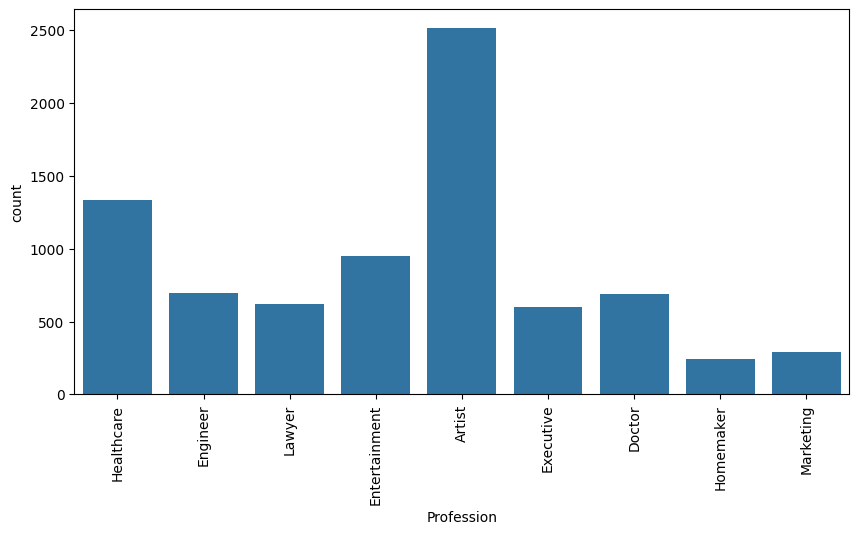

Назва колонки: Var_1
Значення у відсотках:Var_1
Cat_6   0.66
Cat_4   0.14
Cat_3   0.10
Cat_2   0.05
Cat_7   0.03
Cat_1   0.02
Cat_5   0.01
Name: proportion, dtype: float64
Відсоток пропущених значень: 0.94




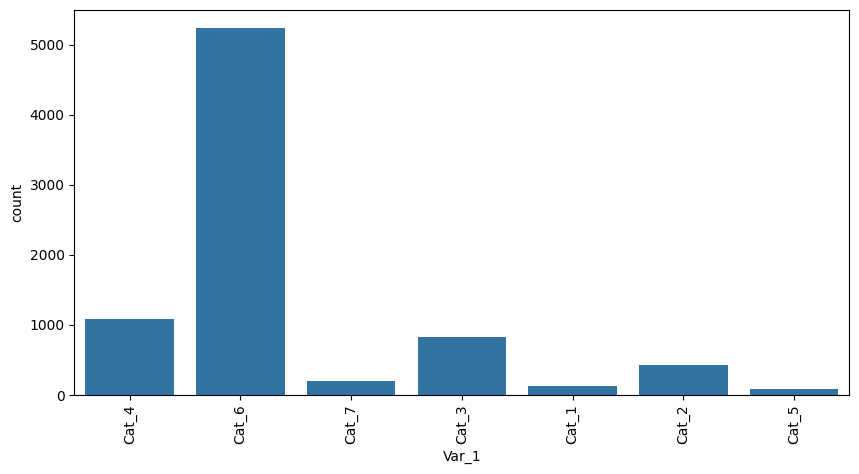

In [97]:
info_df_null_c(df)

###Робота над даними

In [134]:
#визначення типів колонок
asis_col = ['ID']
target = ['Segmentation']
numeric_cols = df.select_dtypes(include=np.number).columns.difference(asis_col).tolist()
categorical_cols = df.select_dtypes('object').columns.difference(target).tolist()

In [135]:
#Заповнення пропущених даних
hip_2(df)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.00,Low,4.00,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,3.00,Average,3.00,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.00,Low,1.00,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.00,High,2.00,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,3.00,High,6.00,Cat_6,A
...,...,...,...,...,...,...,...,...,...,...,...
8063,464018,Male,No,22,No,Unknown,0.00,Low,7.00,Cat_1,D
8064,464685,Male,No,35,No,Executive,3.00,Low,4.00,Cat_4,D
8065,465406,Female,No,33,Yes,Healthcare,1.00,Low,1.00,Cat_6,D
8066,467299,Female,No,27,Yes,Healthcare,1.00,Low,4.00,Cat_6,B


In [136]:
#Кодування категоріальних ознак
inputs_enc, encoded_categories, enc_mapping = encod(df, categorical_cols)

In [137]:
inputs_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        8068 non-null   int64  
 1   Age                       8068 non-null   int64  
 2   Work_Experience           8068 non-null   float64
 3   Family_Size               8068 non-null   float64
 4   Segmentation              8068 non-null   object 
 5   Ever_Married_No           8068 non-null   float64
 6   Ever_Married_Unknown      8068 non-null   float64
 7   Ever_Married_Yes          8068 non-null   float64
 8   Gender_Female             8068 non-null   float64
 9   Gender_Male               8068 non-null   float64
 10  Graduated_No              8068 non-null   float64
 11  Graduated_Unknown         8068 non-null   float64
 12  Graduated_Yes             8068 non-null   float64
 13  Profession_Artist         8068 non-null   float64
 14  Professi

In [138]:
#Стандартизація числових колонок
scaler = MinMaxScaler()

In [139]:
scaler.fit(inputs_enc[numeric_cols])

MinMaxScaler()

In [140]:
inputs_enc[numeric_cols] = scaler.transform(inputs_enc[numeric_cols])

In [110]:
inputs_enc[numeric_cols].describe().round(2)

,Age,Family_Size,Work_Experience
count,8068.00,8068.00,8068.00
mean,0.36,0.23,0.19
std,0.24,0.19,0.23
min,0.00,0.00,0.00
25%,0.17,0.12,0.00
50%,0.31,0.23,0.07
75%,0.49,0.38,0.29
max,1.00,1.00,1.00


##Розбиття на датасети

In [111]:
inputs_enc.columns

Index(['ID', 'Age', 'Work_Experience', 'Family_Size', 'Segmentation',
       'Ever_Married_No', 'Ever_Married_Unknown', 'Ever_Married_Yes',
       'Gender_Female', 'Gender_Male', 'Graduated_No', 'Graduated_Unknown',
       'Graduated_Yes', 'Profession_Artist', 'Profession_Doctor',
       'Profession_Engineer', 'Profession_Entertainment',
       'Profession_Executive', 'Profession_Healthcare', 'Profession_Homemaker',
       'Profession_Lawyer', 'Profession_Marketing', 'Profession_Unknown',
       'Spending_Score_Average', 'Spending_Score_High', 'Spending_Score_Low',
       'Var_1_Cat_1', 'Var_1_Cat_2', 'Var_1_Cat_3', 'Var_1_Cat_4',
       'Var_1_Cat_5', 'Var_1_Cat_6', 'Var_1_Cat_7', 'Var_1_Unknown'],
      dtype='object')

In [141]:
input_cols = inputs_enc[['ID', 'Age', 'Work_Experience', 'Family_Size',
       'Ever_Married_No', 'Ever_Married_Unknown', 'Ever_Married_Yes',
       'Gender_Female', 'Gender_Male', 'Graduated_No', 'Graduated_Unknown',
       'Graduated_Yes', 'Profession_Artist', 'Profession_Doctor',
       'Profession_Engineer', 'Profession_Entertainment',
       'Profession_Executive', 'Profession_Healthcare', 'Profession_Homemaker',
       'Profession_Lawyer', 'Profession_Marketing', 'Profession_Unknown',
       'Spending_Score_Average', 'Spending_Score_High', 'Spending_Score_Low',
       'Var_1_Cat_1', 'Var_1_Cat_2', 'Var_1_Cat_3', 'Var_1_Cat_4',
       'Var_1_Cat_5', 'Var_1_Cat_6', 'Var_1_Cat_7', 'Var_1_Unknown']]
target_col = inputs_enc['Segmentation']

In [142]:
#Devide for datasets
train_inputs, val_inputs, train_targets, val_targets = train_test_split(input_cols, target_col, test_size=0.2, random_state=12, stratify=target_col)

#Завдання_2. Застосування ресамплингу

**Завдання 2. Важливо уважно прочитати все формулювання цього завдання до кінця!**

Застосуйте методи ресемплингу даних SMOTE та SMOTE-Tomek з бібліотеки imbalanced-learn до тренувальної вибірки. В результаті у Вас має вийти 2 тренувальних набори: з апсемплингом зі SMOTE, та з ресамплингом з SMOTE-Tomek.

Увага! В нашому наборі даних є як категоріальні дані, так і звичайні числові. Базовий SMOTE не буде правильно працювати з категоріальними даними, але є його модифікація, яка буде. Тому в цього завдання є 2 виконання

  1. Застосувати SMOTE базовий лише на НЕкатегоріальних ознаках і порівняти лін регресію на апсампл даних без категоріальних ознак.

  2. Переглянути інформацію про метод [SMOTENC](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC) і використати цей метод в цій задачі. За цей спосіб буде +3 бали за це завдання і він рекомендований для виконання.

  **Підказка**: аби скористатись SMOTENC треба створити змінну, яка містить індекси ознак, які є категоріальними (їх номер серед колонок) і передати при ініціації екземпляра класу `SMOTENC(..., categorical_features=cat_feature_indeces)`.
  
  Ви також можете розглянути варіант використання варіації SMOTE, який працює ЛИШЕ з категоріальними ознаками [SMOTEN](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTEN.html)

##SMOTENC

In [143]:
X_smotenc, y_smotenc = stomenc_df_train(train_inputs, encoded_categories, train_targets)

##SMOTE-Tomek

In [144]:
smotetomek = SMOTETomek(random_state=0)
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(train_inputs, train_targets)

#Завдання_3. Навчання моделі та аналіз метрик

**Завдання 3**.
  1. Навчіть модель логістичної регресії з використанням стратегії One-vs-Rest з логістичною регресією на оригінальних даних, збалансованих з SMOTE, збалансованих з Smote-Tomek.  
  2. Виміряйте якість кожної з натренованих моделей використовуючи `sklearn.metrics.classification_report`.
  3. Напишіть, яку метрику ви обрали для порівняння моделей.
  4. Яка модель найкраща?
  5. Якщо немає суттєвої різниці між моделями - напишіть свою гіпотезу, чому?

##SMOTENC

####OneVSRest

In [145]:
log_reg = LogisticRegression(solver='liblinear')
ovr_model = OneVsRestClassifier(log_reg)

In [146]:
ovr_model.fit(X_smotenc, y_smotenc)

OneVsRestClassifier(estimator=LogisticRegression(solver='liblinear'))

In [147]:
ovr_predictions_enc = ovr_model.predict(val_inputs)

In [148]:
# Обчислимо метрики precision та recall для кожного класу
print(classification_report(val_targets, ovr_predictions_enc))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00       394
           B       0.00      0.00      0.00       372
           C       0.24      1.00      0.39       394
           D       0.00      0.00      0.00       454

    accuracy                           0.24      1614
   macro avg       0.06      0.25      0.10      1614
weighted avg       0.06      0.24      0.10      1614



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


####OneVsOne

In [149]:
log_reg = LogisticRegression(solver='liblinear')
ovo_model = OneVsOneClassifier(log_reg)

In [150]:
ovo_model.fit(X_smotenc, y_smotenc)

OneVsOneClassifier(estimator=LogisticRegression(solver='liblinear'))

In [151]:
ovo_predictions_enc = ovo_model.predict(val_inputs)

In [152]:
# Обчислимо метрики precision та recall для кожного класу
print(classification_report(val_targets, ovo_predictions_enc))

              precision    recall  f1-score   support

           A       0.40      0.45      0.42       394
           B       0.36      0.25      0.29       372
           C       0.50      0.58      0.54       394
           D       0.66      0.66      0.66       454

    accuracy                           0.49      1614
   macro avg       0.48      0.48      0.48      1614
weighted avg       0.49      0.49      0.49      1614



####Аналіз коефіцієнтів ознак моделі

#####OneVsRest

In [124]:
inner_models = ovr_model.estimators_
coefficients = inner_models[0].coef_
feature_names = X_smotenc.columns
# Перетворення масиву коефіцієнтів у одновимірний масив (якщо потрібно)
inner_models = ovr_model.estimators_
coefficients = inner_models[0].coef_
coefficients = coefficients.ravel()

# Створення DataFrame для зручності відображення
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Виведення DataFrame з відсортованими за абсолютною величиною коефіцієнтів
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

print(coef_df)

                     Feature  Coefficient
0                         ID        -0.00
30               Var_1_Cat_6        -0.00
11             Graduated_Yes        -0.00
6           Ever_Married_Yes        -0.00
8                Gender_Male        -0.00
22    Spending_Score_Average        -0.00
17     Profession_Healthcare        -0.00
12         Profession_Artist        -0.00
7              Gender_Female        -0.00
3                Family_Size        -0.00
9               Graduated_No        -0.00
4            Ever_Married_No        -0.00
1                        Age        -0.00
24        Spending_Score_Low        -0.00
23       Spending_Score_High        -0.00
2            Work_Experience        -0.00
16      Profession_Executive        -0.00
15  Profession_Entertainment         0.00
26               Var_1_Cat_2        -0.00
27               Var_1_Cat_3        -0.00
20      Profession_Marketing        -0.00
13         Profession_Doctor        -0.00
14       Profession_Engineer      

#####OneVsOne

In [125]:
inner_models = ovo_model.estimators_
coefficients = inner_models[0].coef_
feature_names = X_smotenc.columns
# Перетворення масиву коефіцієнтів у одновимірний масив (якщо потрібно)
inner_models = ovr_model.estimators_
coefficients = inner_models[0].coef_
coefficients = coefficients.ravel()

# Створення DataFrame для зручності відображення
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Виведення DataFrame з відсортованими за абсолютною величиною коефіцієнтів
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

print(coef_df)

                     Feature  Coefficient
0                         ID        -0.00
30               Var_1_Cat_6        -0.00
11             Graduated_Yes        -0.00
6           Ever_Married_Yes        -0.00
8                Gender_Male        -0.00
22    Spending_Score_Average        -0.00
17     Profession_Healthcare        -0.00
12         Profession_Artist        -0.00
7              Gender_Female        -0.00
3                Family_Size        -0.00
9               Graduated_No        -0.00
4            Ever_Married_No        -0.00
1                        Age        -0.00
24        Spending_Score_Low        -0.00
23       Spending_Score_High        -0.00
2            Work_Experience        -0.00
16      Profession_Executive        -0.00
15  Profession_Entertainment         0.00
26               Var_1_Cat_2        -0.00
27               Var_1_Cat_3        -0.00
20      Profession_Marketing        -0.00
13         Profession_Doctor        -0.00
14       Profession_Engineer      

##SMOTE-Tomek

####OneVsRest

In [153]:
ovr_model.fit(X_train_smotetomek, y_train_smotetomek)

OneVsRestClassifier(estimator=LogisticRegression(solver='liblinear'))

In [154]:
ovr_predictions_mek = ovr_model.predict(val_inputs)

In [155]:
# Обчислимо метрики precision та recall для кожного класу
print(classification_report(val_targets, ovr_predictions_mek))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00       394
           B       0.00      0.00      0.00       372
           C       0.24      1.00      0.39       394
           D       0.00      0.00      0.00       454

    accuracy                           0.24      1614
   macro avg       0.06      0.25      0.10      1614
weighted avg       0.06      0.24      0.10      1614



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


####OneVsOne

In [156]:
ovo_model.fit(X_train_smotetomek, y_train_smotetomek)

OneVsOneClassifier(estimator=LogisticRegression(solver='liblinear'))

In [157]:
ovo_predictions_mek = ovo_model.predict(val_inputs)

In [158]:
print(classification_report(val_targets, ovo_predictions_mek))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00       394
           B       0.00      0.00      0.00       372
           C       0.36      0.81      0.50       394
           D       0.52      0.83      0.64       454

    accuracy                           0.43      1614
   macro avg       0.22      0.41      0.28      1614
weighted avg       0.23      0.43      0.30      1614



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##**Висновки**

1. При тренуванні моделі я використала обгортку до логістичної моделі OneVsRest  та OneVsOne для наборів даних, до яких застосовано Smotenc  та SMOTE-Tomek:
  - На обох наборах даних при використанні OneVsRest модель вміла передбачати лише клас С і accurency становило на обох наборах даних 24 відсотки.
  - При використанні OneVsOne на наборі даних оброблених SMOTENC accuracy склало 49 відсотків з варіацією f1_score по класам від 30 до 65 відсотків. На наборі даних обробленому SMOTE-Tomek: accuracy склало 43 відсотки і передбачало лише 2 класи: 50 і 64 відсотки.
  - Варіації заповнення нульових значень, та розбиття на категорії ряду числових колонок не впливали на показники моделі, тому зупинилась на заповнені медіаною та середнім, а категоріальних значенням Unknown.
  - Аналіз коефіцієнтів показників показав, що в обох методах вирішення всі коефіцієнти дуже низькі.
2. Для аналізу моделей я обрала такі метрики: accurancy - для загальної оцінки моделі, f1_score - для аналізу роботи моделі щодо визначення окремих класів.
3. Із натренованих мною моделей найкращі показники має логістична модель+ OneVsOne на даних оброблених SMOTENK
4. Результати моделей у мене відрізняються не за способами ресамплингу, а застосованими способами тренування.
